In [1]:
import zipfile
import random
import tensorflow as tf
from tensorflow import keras
import h5py
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *

from keras import optimizers
import scipy
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import imageio
import pandas as pd
from keras.models import *

from keras import regularizers

2024-10-27 09:37:34.348574: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-27 09:37:34.521920: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-27 09:37:34.606547: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-27 09:37:34.628543: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-27 09:37:34.746892: I tensorflow/core/platform/cpu_feature_guar

In [2]:
tf.keras.backend.clear_session(
    free_memory=True
)

In [3]:
axial_data_dir = '/home/user/Desktop/personal/linkon/Alzheimer/ADNI/NEW_edited/axial_masked'

saggital_data_dir = '/home/user/Desktop/personal/linkon/Alzheimer/ADNI/NEW_edited/saggital_masked'
coronal_data_dir = '/home/user/Desktop/personal/linkon/Alzheimer/ADNI/NEW_edited/coronal_masked'


# print(os.listdir(data_dir))






In [4]:
def data_path(data_dir):    
    train_images = []
    train_labels = []

    for folder in os.listdir(data_dir):
        subfolder_path2=os.path.join(data_dir,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            train_images.append(image_path)
            train_labels.append(folder)
    train_df= pd.DataFrame({'image': train_images, 'label': train_labels})
    return train_df

In [5]:
axial = data_path(axial_data_dir)
saggital = data_path( saggital_data_dir)
coronal = data_path(coronal_data_dir)

In [6]:
merged_df = pd.concat([axial, saggital, coronal], axis=0)
all_df = merged_df.reset_index(drop=True)
all_df['label'].value_counts()

label
MCI    18960
CN     11640
AD      7980
Name: count, dtype: int64

In [7]:
all_df_edited = all_df.sample(frac=1, random_state=42).reset_index(drop=True)
all_df_edited.head()

image label
0  /home/user/Desktop/personal/linkon/Alzheimer/A...    CN
1  /home/user/Desktop/personal/linkon/Alzheimer/A...   MCI
2  /home/user/Desktop/personal/linkon/Alzheimer/A...    AD
3  /home/user/Desktop/personal/linkon/Alzheimer/A...    AD
4  /home/user/Desktop/personal/linkon/Alzheimer/A...   MCI

In [8]:
# all_df_edited['label'] =all_df_edited['label'].replace({'Final CN JPEG': 'CN', 'Final AD JPEG': 'AD',
#                                                         'Final MCI JPEG': 'MCI', 'Final EMCI JPEG': 'EMCI',
#                                                         'Final LMCI JPEG': 'LMCI'})
# print(all_df_edited['label'].value_counts())

In [9]:

all_df_edited = all_df_edited[(all_df_edited['label'] == 'AD') | 
                                (all_df_edited['label'] == 'CN') | 
                                (all_df_edited['label'] == 'MCI')]
all_df_edited = all_df_edited.sample(frac=1, random_state=42).reset_index(drop=True)
print(all_df_edited['label'].value_counts())

label
MCI    18960
CN     11640
AD      7980
Name: count, dtype: int64


/tmp/ipykernel_13256/3004188932.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=all_df_edited.label, palette='Set2')


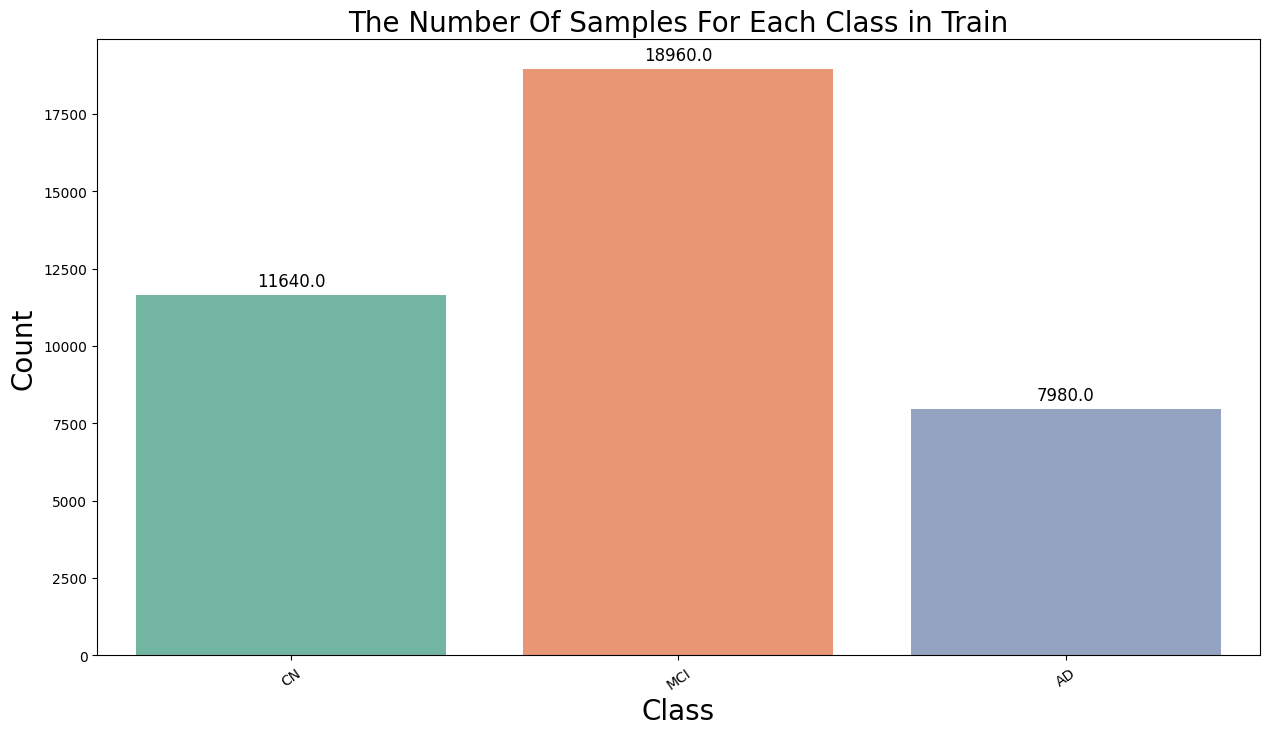

In [10]:
plt.figure(figsize=(15, 8))
ax = sns.countplot(x=all_df_edited.label, palette='Set2')
ax.set_xlabel("Class", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
plt.title('The Number Of Samples For Each Class in Train', fontsize=20)
plt.grid(False)
plt.xticks(rotation=35)

# Add counts on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points', 
                fontsize=12)

plt.show()

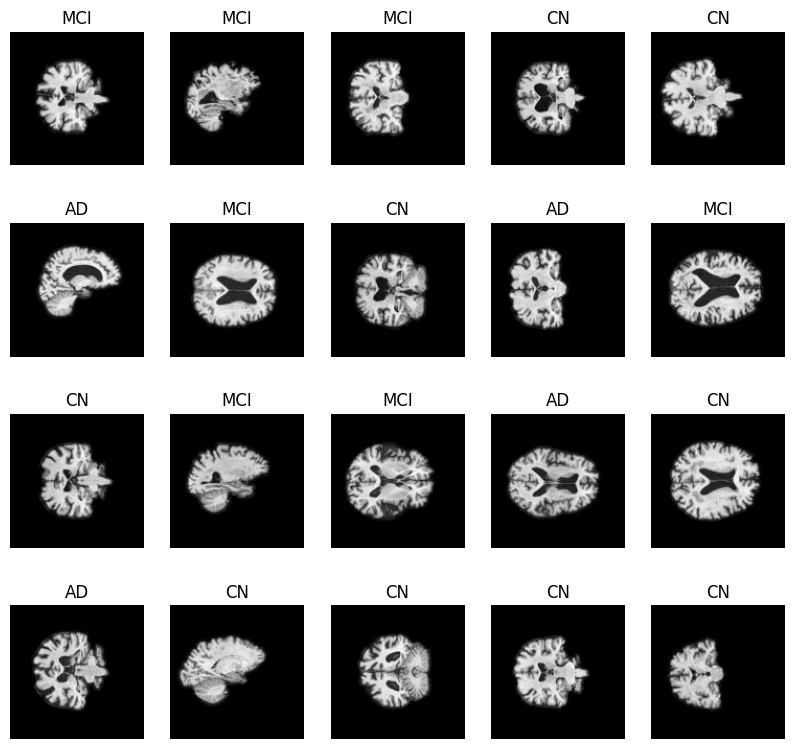

In [11]:
plt.figure(figsize=(10,12))

for n,i in enumerate(np.random.randint(0,len(all_df_edited),20)):
    plt.subplot(5,5,n+1)
    img=cv2.imread(all_df_edited.image[i])
    img=cv2.resize(img,(128,128))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(all_df_edited.label[i],fontsize=12)

# See some image processing


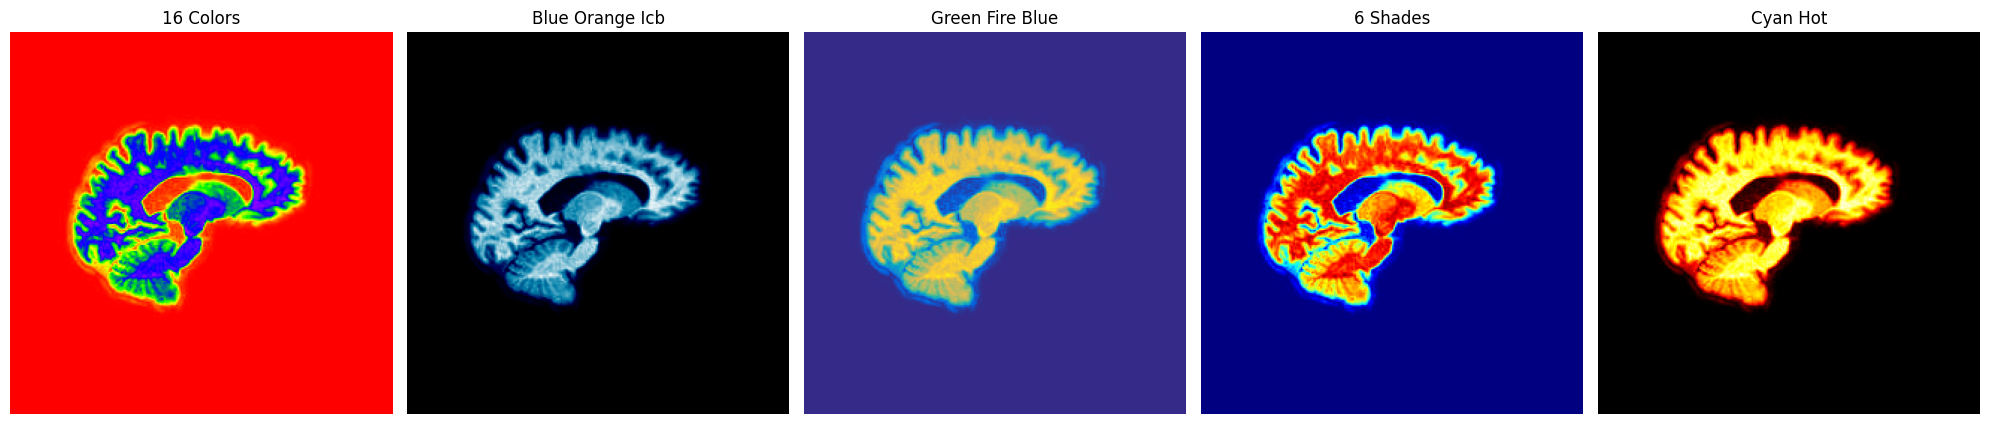

In [12]:
image = cv2.imread(all_df_edited.image[2])
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
color_maps = {
    '16 Colors': cv2.COLORMAP_RAINBOW,
    'Blue Orange Icb': cv2.COLORMAP_OCEAN,
    'Green Fire Blue': cv2.COLORMAP_PARULA,
    '6 Shades': cv2.COLORMAP_JET,
    'Cyan Hot': cv2.COLORMAP_HOT,
}

fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

# Apply colormaps and plot each image
for ax, (name, cmap) in zip(axes, color_maps.items()):
    colored_image = cv2.applyColorMap(image, cmap)
    colored_image_rgb = cv2.cvtColor(colored_image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
    ax.imshow(colored_image_rgb)
    ax.set_title(name)
    ax.axis('off')  # Hide axes

# Display the figure
plt.tight_layout()
plt.show()

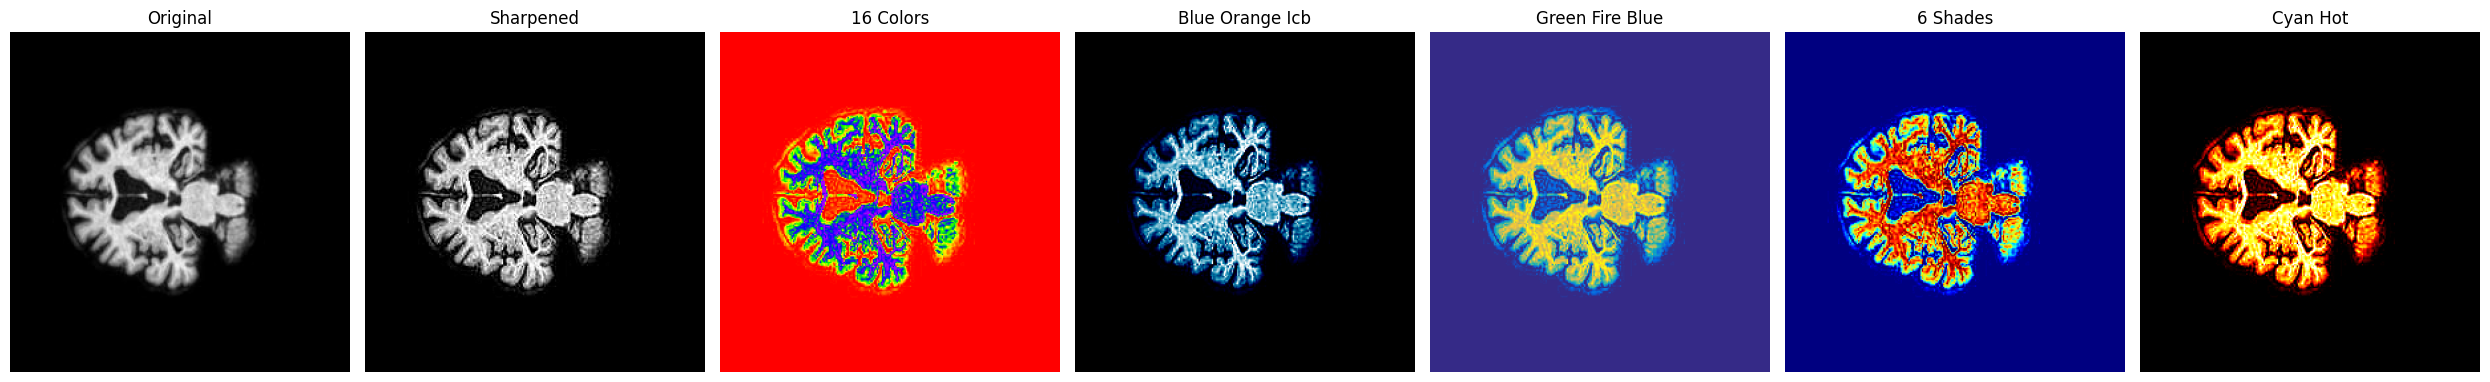

In [13]:
image = cv2.imread(all_df_edited.image[34])
# image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

# Apply the sharpening filter using filter2D
sharpened = cv2.filter2D(image, -1, kernel)

# Convert the original and sharpened images from BGR to RGB for matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
sharpened_rgb = cv2.cvtColor(sharpened, cv2.COLOR_BGR2RGB)

# Define colormaps
color_maps = {
    '16 Colors': cv2.COLORMAP_RAINBOW,
    'Blue Orange Icb': cv2.COLORMAP_OCEAN,
    'Green Fire Blue': cv2.COLORMAP_PARULA,
    '6 Shades': cv2.COLORMAP_JET,
    'Cyan Hot': cv2.COLORMAP_HOT,
}

# Create a figure with 1 row and 7 columns (2 for original and sharpened, 5 for color maps)
fig, axes = plt.subplots(1, 7, figsize=(25, 5))

# Display Original Image
axes[0].imshow(image_rgb)
axes[0].set_title('Original')
axes[0].axis('off')

# Display Sharpened Image
axes[1].imshow(sharpened_rgb)
axes[1].set_title('Sharpened')
axes[1].axis('off')

# Apply colormaps and plot each image
for ax, (name, cmap) in zip(axes[2:], color_maps.items()):
    colored_image = cv2.applyColorMap(sharpened_rgb, cmap)
    colored_image_rgb = cv2.cvtColor(colored_image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
    ax.imshow(colored_image_rgb)
    ax.set_title(name)
    ax.axis('off')  # Hide axes

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

In [14]:
len(all_df_edited)

38580

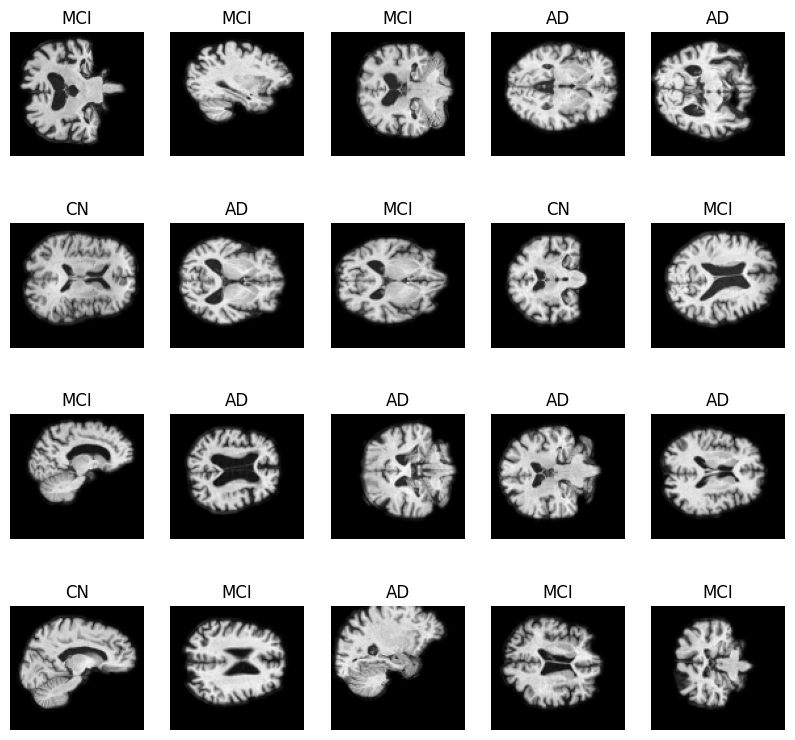

In [15]:
plt.figure(figsize=(10,12))

for n,i in enumerate(np.random.randint(0,len(all_df_edited),20)):
    plt.subplot(5,5,n+1)
    img=cv2.imread(all_df_edited.image[i])
    img=cv2.resize(img,(128,128))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    cropped_image = img[20:115, 8:110]
    plt.imshow(cropped_image)
    plt.axis('off')
    plt.title(all_df_edited.label[i],fontsize=12)

In [16]:
temp_df_edited, test_df_edited = train_test_split(all_df_edited, test_size=0.15, stratify=all_df_edited['label'], random_state=43)
train_df_edited, val_df_edited = train_test_split(temp_df_edited, test_size=0.15, stratify=temp_df_edited['label'], random_state=43)


train_df_edited = train_df_edited.reset_index(drop=True)
val_df_edited = val_df_edited.reset_index(drop=True)
test_df_edited = test_df_edited.reset_index(drop=True)
train_df_edited.shape, test_df_edited.shape, val_df_edited.shape

((27874, 2), (5787, 2), (4919, 2))

/tmp/ipykernel_13256/1169724873.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=test_df_edited.label, palette='Set2')


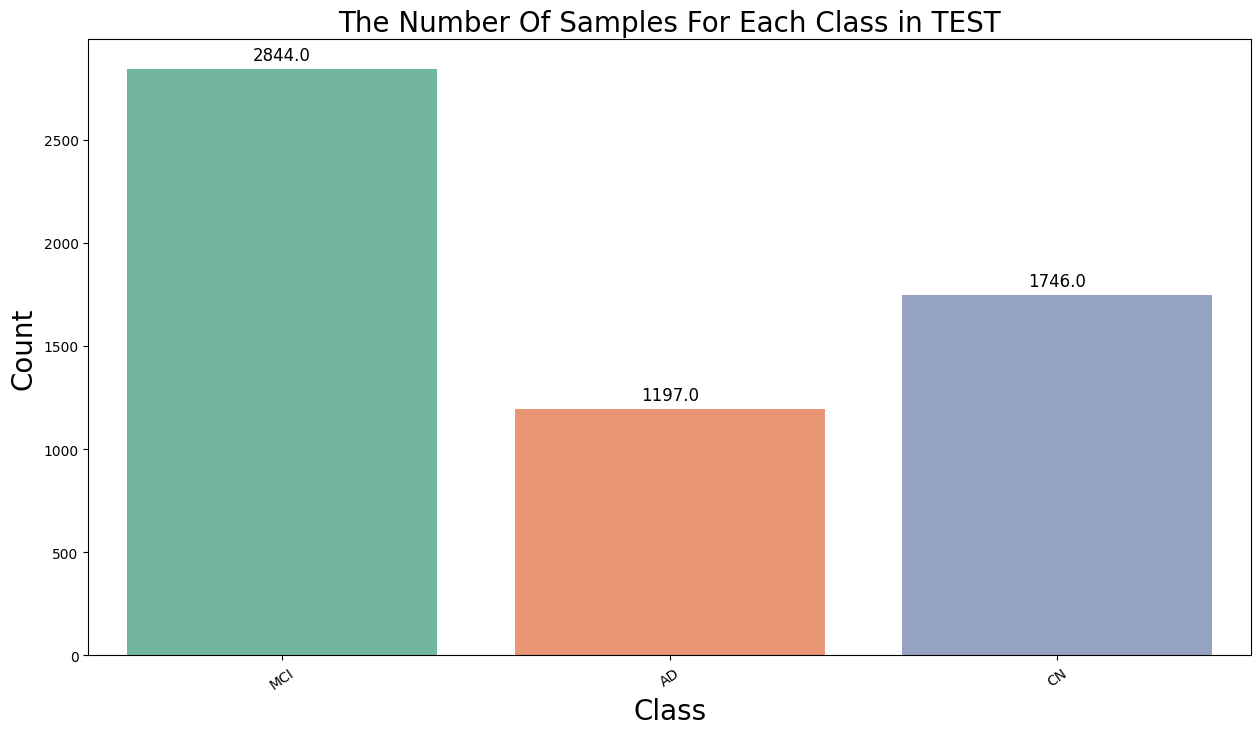

In [17]:
plt.figure(figsize=(15, 8))
ax = sns.countplot(x=test_df_edited.label, palette='Set2')
ax.set_xlabel("Class", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
plt.title('The Number Of Samples For Each Class in TEST', fontsize=20)
plt.grid(False)
plt.xticks(rotation=35)

# Add counts on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points', 
                fontsize=12)

plt.show()

/tmp/ipykernel_13256/3995720465.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=train_df_edited.label, palette='Set2')


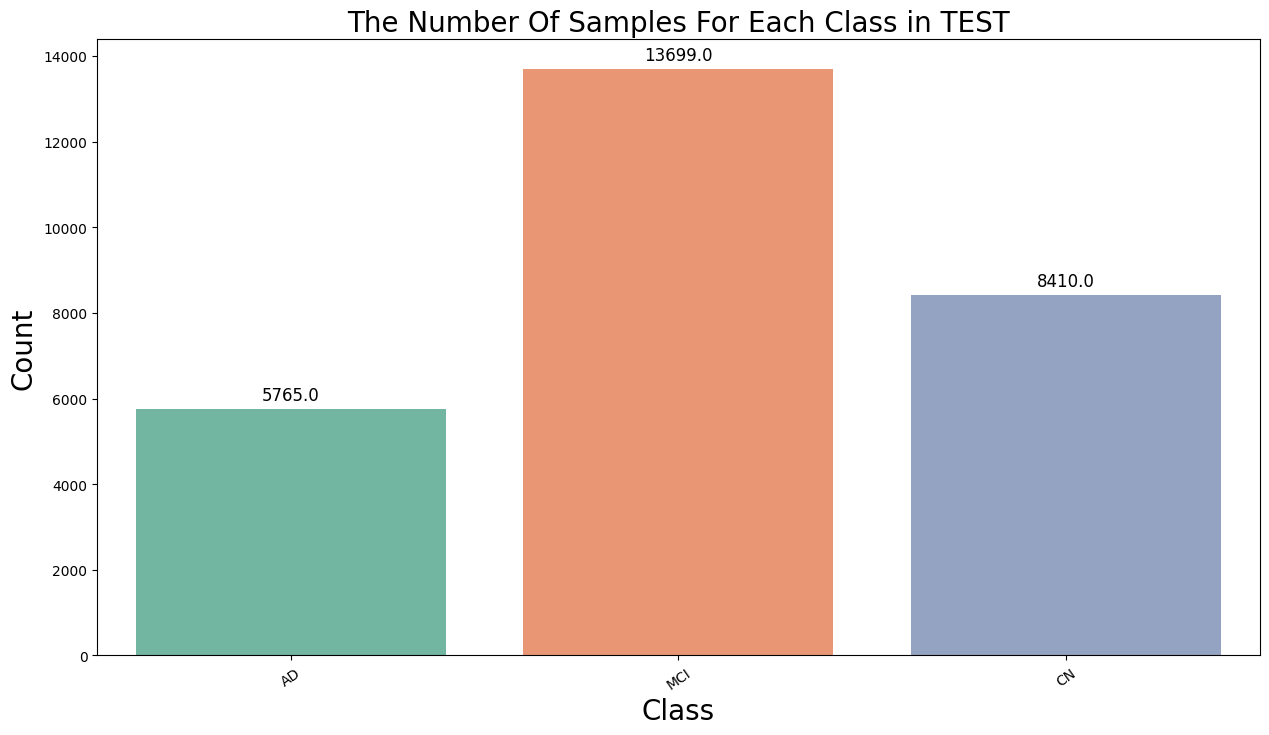

In [18]:
plt.figure(figsize=(15, 8))
ax = sns.countplot(x=train_df_edited.label, palette='Set2')
ax.set_xlabel("Class", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
plt.title('The Number Of Samples For Each Class in TEST', fontsize=20)
plt.grid(False)
plt.xticks(rotation=35)

# Add counts on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points', 
                fontsize=12)

plt.show()

In [19]:
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical

In [20]:
# image = cv2.imread('/home/user/Desktop/personal/linkon/Alzheimer/ADNI/new/axial_masked_edited/AD/I31143_100.jpg')
        
# image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image_rgb = cv2.rotate(image_rgb, cv2.ROTATE_90_CLOCKWISE)
# plt.imshow(image_rgb)

In [21]:
def load_resize_normalize_data(df, target_size=(128, 128)):
    images = []
    labels = []
    
    label_encoder = LabelEncoder()
    for index, row in df.iterrows():
   
        image_path = row['image']
        image = cv2.imread(image_path)
        kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

        # Apply the sharpening filter using filter2D
        sharpened = cv2.filter2D(image, -1, kernel)

        # # Convert the original and sharpened images from BGR to RGB for matplotlib
        # image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        sharpened_rgb = cv2.cvtColor(sharpened, cv2.COLOR_BGR2RGB)
        resized_image = cv2.resize(sharpened_rgb, (128,128))
        cropped_image =resized_image[8: 120, 10: 118]
        resized_image = cv2.resize(cropped_image, (128,128))
        resized_image = cv2.rotate(resized_image, cv2.ROTATE_90_CLOCKWISE)

        

        normalized_image = resized_image / 255.0 
        
        # Store the resized and normalized image and its corresponding label
        images.append(normalized_image)
        labels.append(row['label'])
  
    encoded_labels_lb = label_encoder.fit_transform(labels)
    
    class_mapping ={  'AD':0,'CN':1, 'MCI': 2}
    
    y_mapped =df['label'].map(class_mapping)
    y_one_hot = to_categorical(y_mapped, num_classes=3)
    return np.array(images), np.array(encoded_labels_lb), label_encoder.classes_, y_one_hot




In [22]:
train_images, train_encoded_labels, classes, train_one_hot = load_resize_normalize_data(train_df_edited)



In [23]:
train_datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, 
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, 
     horizontal_flip=True)

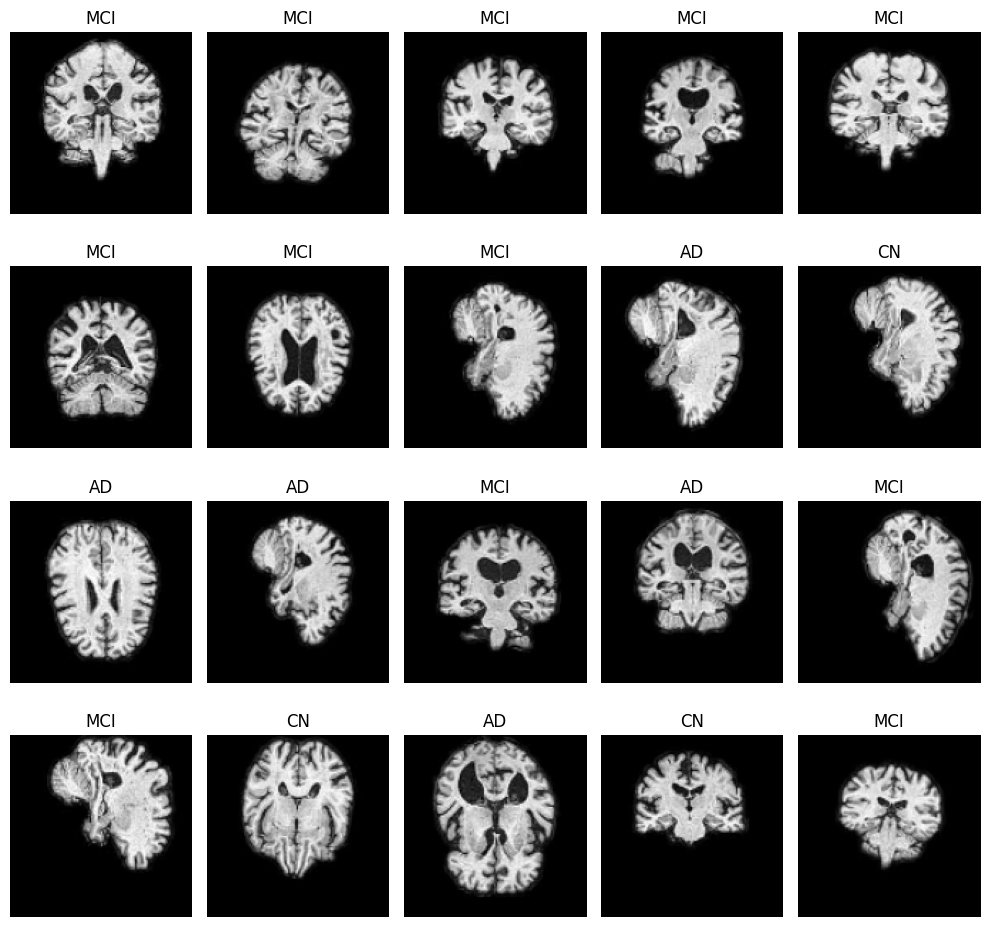

In [24]:
label_decoder = {0:'AD', 1: 'CN', 2: 'MCI'}

plt.figure(figsize=(10, 12))

for n, i in enumerate(np.random.randint(0, len(train_images), 20)):
    plt.subplot(5, 5, n + 1)
    img = train_images[i]
    plt.imshow(img)
    plt.axis('off')
    plt.title(label_decoder[train_encoded_labels[i]], fontsize=12)

plt.tight_layout()

# Train Data Balance

In [25]:
df_train = pd.DataFrame({'image': list(train_images), 'label': train_encoded_labels})

minority_classes = [0] #AD, CM
majority_class = 1 # MCI
most_major = 2# CN

In [26]:
minority_dfs = [df_train[df_train['label'] == c] for c in minority_classes]
majority_df = df_train[df_train['label'] == majority_class]
most_major_df = df_train[df_train['label'] == most_major]

In [27]:
num_majority = len(majority_df)

In [28]:
augmented_images = []
augmented_labels = []

for minority_df in minority_dfs:
    num_minority = len(minority_df)
    num_to_augment = 1000#num_majority - num_minority

    if num_to_augment > 0:  # Only augment if necessary
        minority_images = np.array(minority_df['image'].tolist())
        minority_labels = np.array(minority_df['label'].tolist())

        augmented_minority_images = []
        augmented_minority_labels = []

        total_augmented_images = 0
        batch_size = 8

        

        while total_augmented_images < num_to_augment:
            batch_images, batch_labels = next(train_datagen.flow(minority_images, minority_labels, batch_size=batch_size))

            remaining_to_augment = num_to_augment - total_augmented_images
            images_to_add = min(remaining_to_augment, batch_size)

            augmented_minority_images.extend(batch_images[:images_to_add])
            augmented_minority_labels.extend(batch_labels[:images_to_add])

            total_augmented_images += images_to_add
            if total_augmented_images % 200 == 0:
                print(f'{total_augmented_images} images augmented so far')

        augmented_images.extend(augmented_minority_images)
        augmented_labels.extend(augmented_minority_labels)

200 images augmented so far
400 images augmented so far
600 images augmented so far
800 images augmented so far
1000 images augmented so far


In [29]:
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)


balanced_images = np.concatenate([np.array(df_train[df_train['label'] == c]['image'].tolist()) for c in minority_classes] + [augmented_images], axis=0)
balanced_labels = np.concatenate([np.array(df_train[df_train['label'] == c]['label'].tolist()) for c in minority_classes] + [augmented_labels], axis=0)

In [30]:
balanced_images.shape

(6765, 128, 128, 3)

In [31]:
# majority_images = np.array(majority_df['image'].tolist())
# majority_labels = np.array(majority_df['label'].tolist())
# majority_images.shape

majority_images = np.concatenate((np.array(majority_df['image'].tolist()), np.array(most_major_df['image'].tolist())), axis=0)
majority_labels = np.concatenate((np.array(majority_df['label'].tolist()), np.array(most_major_df['label'].tolist())), axis=0)
majority_images.shape

(22109, 128, 128, 3)

In [32]:
all_train_images= np.concatenate((majority_images, balanced_images), axis=0)
all_train_labels= np.concatenate((majority_labels, balanced_labels), axis=0)
all_train_images.shape, all_train_labels.shape



((28874, 128, 128, 3), (28874,))

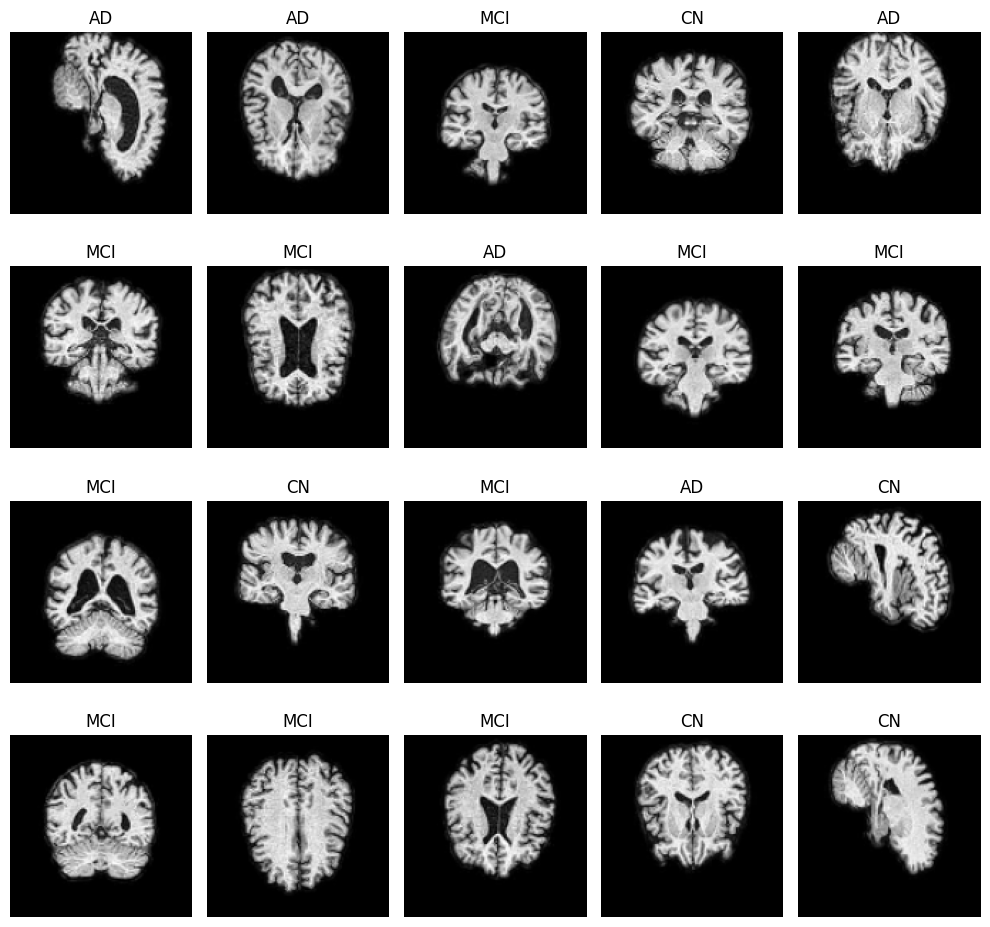

In [33]:
label_decoder = {0:'AD', 1: 'CN', 2: 'MCI'}
plt.figure(figsize=(10, 12))

for n, i in enumerate(np.random.randint(0, len(all_train_images), 20)):
    plt.subplot(5, 5, n + 1)
    img = all_train_images[i]
    plt.imshow(img)
    plt.axis('off')
    plt.title(label_decoder[all_train_labels[i]], fontsize=12)

plt.tight_layout()
plt.show()

/tmp/ipykernel_13256/1590062880.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=all_train_labels, palette='Set2')


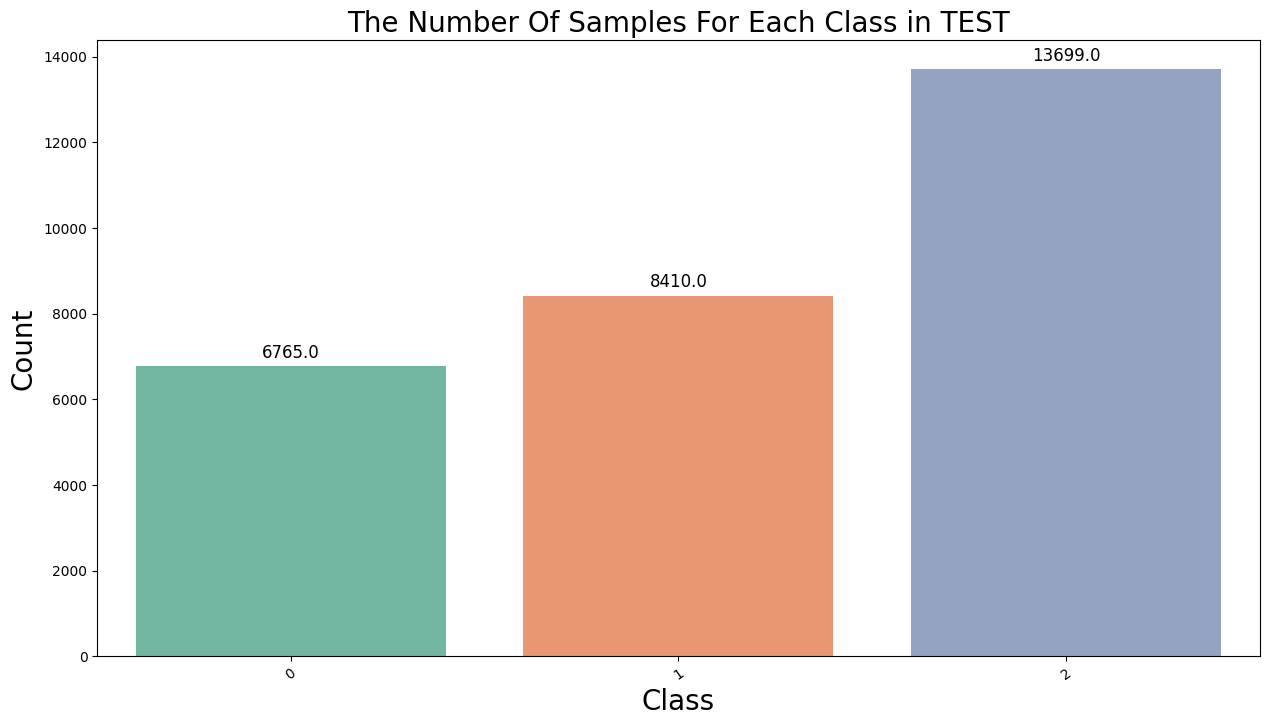

In [34]:
plt.figure(figsize=(15, 8))
ax = sns.countplot(x=all_train_labels, palette='Set2')
ax.set_xlabel("Class", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
plt.title('The Number Of Samples For Each Class in TEST', fontsize=20)
plt.grid(False)
plt.xticks(rotation=35)

# Add counts on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points', 
                fontsize=12)

plt.show()

# Val Processing

In [35]:
val_images, val_encoded_labels, val_classes, val_one_hot = load_resize_normalize_data(val_df_edited)



In [36]:
print("Shape of images array:", val_images.shape)
print("Shape of encoded labels array:", val_encoded_labels.shape)
print("Classes:", val_classes)
# print("One HOt clases:", val_one_hot)
print("One HOt clases:", val_one_hot.shape)

Shape of images array: (4919, 128, 128, 3)
Shape of encoded labels array: (4919,)
Classes: ['AD' 'CN' 'MCI']
One HOt clases: (4919, 3)


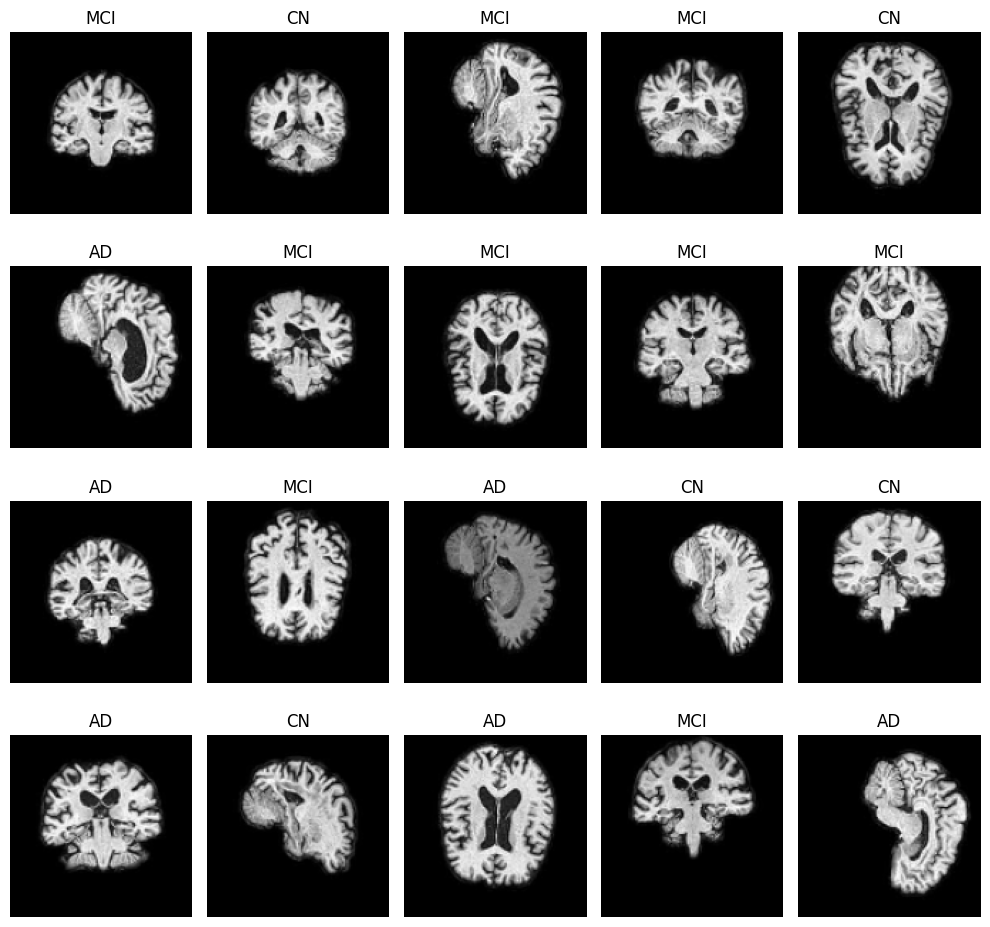

In [37]:
label_decoder = {0:'AD', 1: 'CN', 2: 'MCI'}

plt.figure(figsize=(10, 12))

for n, i in enumerate(np.random.randint(0, len(val_images), 20)):
    plt.subplot(5, 5, n + 1)
    img = val_images[i]
    plt.imshow(img)
    plt.axis('off')
    plt.title(label_decoder[val_encoded_labels[i]], fontsize=12)

plt.tight_layout()
plt.show()

# Test preprocessing

In [38]:
test_images, test_encoded_labels, test_classes, test_one_hot = load_resize_normalize_data(test_df_edited)



In [39]:
print("Shape of images array:", test_images.shape)
print("Shape of encoded labels array:", test_encoded_labels.shape)
print("Classes:", test_classes)
# print("One HOt clases:", test_one_hot)
print("One HOt clases:", test_one_hot.shape)

Shape of images array: (5787, 128, 128, 3)
Shape of encoded labels array: (5787,)
Classes: ['AD' 'CN' 'MCI']
One HOt clases: (5787, 3)


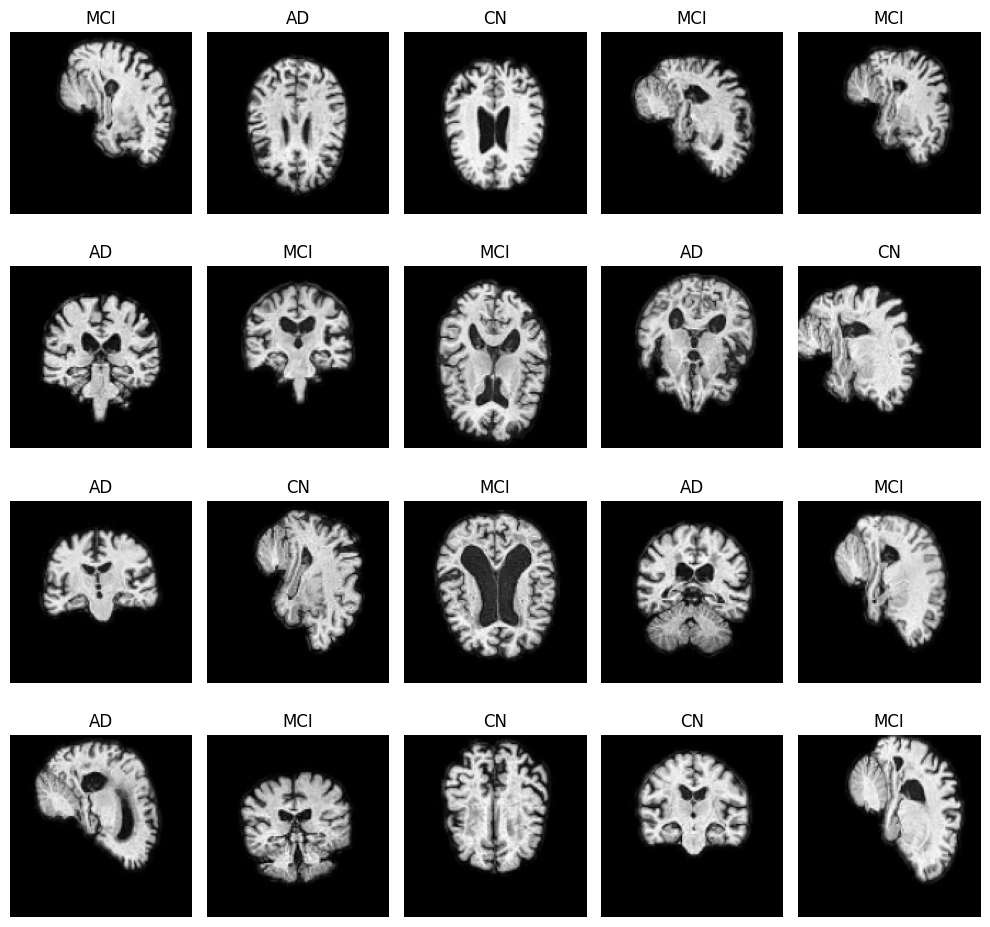

In [40]:
label_decoder = {0:'AD', 1: 'CN', 2: 'MCI'}

plt.figure(figsize=(10, 12))

for n, i in enumerate(np.random.randint(0, len(test_images), 20)):
    plt.subplot(5, 5, n + 1)
    img = test_images[i]
    plt.imshow(img)
    plt.axis('off')
    plt.title(label_decoder[test_encoded_labels[i]], fontsize=12)

plt.tight_layout()
plt.show()

# Data generator

In [41]:
valid_datagen = ImageDataGenerator(
    preprocessing_function=None 
)


In [42]:
batch_size=8
# train_gen = train_datagen.flow(train_images, train_one_hot, batch_size=batch_size, shuffle=True)
val_gen = valid_datagen.flow(val_images, val_one_hot, batch_size=8, shuffle=False)
test_gen = valid_datagen.flow(test_images, test_one_hot, batch_size=1, shuffle=False)

In [43]:
from keras import backend as K

IMG_CHANNELS=3
IMG_WIDTH = 128
IMG_HEIGHT = 128

if K.image_data_format() == 'channels_first':
    input_shape = (IMG_CHANNELS, IMG_WIDTH, IMG_HEIGHT)
else:
    input_shape = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

In [44]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import *
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(
        initial_learning_rate,
        decay_steps=10000,
        decay_rate=0.8,
        staircase=True)


print(lr_schedule.get_config())


{'initial_learning_rate': 0.0001, 'decay_steps': 10000, 'decay_rate': 0.8, 'staircase': True, 'name': 'ExponentialDecay'}


In [45]:
class ExpandDimsLayer(Layer):
    def __init__(self, axis, **kwargs):
        super(ExpandDimsLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)

In [46]:
class Reshapelayer(Layer):
    def __init__(self, dim, **kwargs):
        super(Reshapelayer, self).__init__(**kwargs)
        self.dim = dim

    def call(self, inputs):
        return tf.reshape(inputs, [tf.shape(inputs)[0], self.dim, 1])

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dim, 1)
    
    
class ReduceMeanLayer(Layer):
    def __init__(self, axis, **kwargs):
        super(ReduceMeanLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=self.axis)

In [47]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [48]:
class RootMeanSquaredError(tf.keras.metrics.Metric):
    def __init__(self, name='rmse', **kwargs):
        super(RootMeanSquaredError, self).__init__(name=name, **kwargs)
        self.mse = tf.keras.metrics.MeanSquaredError()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.mse.update_state(y_true, y_pred, sample_weight)

    def result(self):
        return tf.sqrt(self.mse.result())

    def reset_states(self):
        self.mse.reset_states()

In [49]:
class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
    def build(self, input_shape):
        self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

    def call(self, inputs):
        avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)
            
            # MaxPool
        max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

        attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

        attention = self.conv2d(attention)


        return tf.keras.layers.multiply([inputs, attention])

In [50]:
def multires_block2D(U, x, alpha=1.67, strides=1):
    kernel_initializer = 'he_normal'
    W = U * alpha
    shortcut = Conv2D(int(W*0.167) + int(W*0.333) + int(W*0.5), kernel_size=(1, 1), padding='same',
                      use_bias=False, kernel_initializer=kernel_initializer)(x)
    
    # Multi-resolution paths with Conv2D
    conv6 = Conv2D(int(W*0.167), kernel_size=(3, 3), padding='same', use_bias=False,
                   kernel_initializer=kernel_initializer)(shortcut)
    conv11 = Conv2D(int(W*0.333), kernel_size=(3, 3), padding='same', use_bias=False,
                    kernel_initializer=kernel_initializer)(conv6)
    conv17 = Conv2D(int(W*0.5), kernel_size=(3, 3), padding='same', use_bias=False,
                    kernel_initializer=kernel_initializer)(conv11)
    
    # Concatenate the multi-resolution outputs
    out = tf.keras.layers.concatenate([conv6, conv11, conv17], axis=-1)
    out = LayerNormalization(axis=-1)(out, training=True)
    
    # Add the skip connection
    out = Add()([out, shortcut])
    
    # Final Conv2D layer with strides
    out = Conv2D(int(W*0.167) + int(W*0.333) + int(W*0.5), kernel_size=(5, 5), padding='same',
                 strides=strides, use_bias=False, kernel_initializer=kernel_initializer)(out)
    out = Activation('relu')(out)
    out = LayerNormalization(axis=-1)(out, training=True)
    
    return out

In [51]:
def line1(x):
    # received shape: (64, 64, 3)
    kernel_ ='he_normal'
    conv_1 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = kernel_)(x)

    
    block1_conv1 = Conv2D(32, (1, 1), activation='relu', padding='same', kernel_initializer = kernel_)(conv_1)
    block1_pool = MaxPool2D(2, 2)(block1_conv1)

    block2_conv1 = Conv2D(64, (7, 7), activation='relu', padding='same', kernel_initializer = kernel_)(block1_pool)
    block2_pool = MaxPool2D(2, 2)(block2_conv1)
  
    return block2_pool

def line2(x):
    # received shape: (32, 32, 3)


    conv_1 = Conv2D(16, (7, 7), activation='relu', padding='same')(x)
    conv_1 = BatchNormalization()(conv_1, training=True)
    conv_1 = Dropout(0.3)(conv_1)


    block1_conv1 = Conv2D(64, (5, 5), activation='relu', padding='same')(conv_1)
    block1_conv1 = BatchNormalization()(block1_conv1, training=True)
    block1_conv1 = MaxPool2D(2, 2)(block1_conv1)


    return block1_conv1

def line3(x):
    # received shape: (16, 16, 3)


    conv_1 = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    conv_1 = LayerNormalization()(conv_1)

    block1_conv1 = Conv2D(16, (2, 2), activation='relu', padding='same')(conv_1)
    block1_conv1 = LayerNormalization()(block1_conv1)

    block2_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(block1_conv1)
    block2_pool = AvgPool2D(2, 2)(block2_conv1)

    return block2_pool



def line4(x):
    conv_1 = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    conv_1 = Conv2D(64, (14, 14), activation='relu', padding='same')(conv_1)
    conv_1 = MaxPool2D(pool_size=(2,2))(conv_1)
    conv_1 = BatchNormalization()(conv_1, training=True)
#     reshaped = Reshape((conv_1.shape[1] * conv_1.shape[2], conv_1.shape[3]))(conv_1)
#     lstm_1 = LSTM(32, return_sequences=True)(reshaped)
#     query_attn = GroupQueryAttention(head_dim=128,num_query_heads=8,num_key_value_heads=4)
#     attention= query_attn(query =conv_1, value= conv_1)

    return conv_1

def line5(x):
    conv_1 = Conv2D(128, (5,5), activation='relu', padding='same')(x)
    conv_1 = Dropout(0.2)(conv_1)
    conv_1 = BatchNormalization()(conv_1)
    
    
    multires_block_1 = multires_block2D(U=32, x= conv_1)
    multires_block_1 = BatchNormalization()(multires_block_1)
    multires_block_1 = multires_block2D(U=64, x= multires_block_1)

    
    reshaped = Reshape((multires_block_1.shape[1] * multires_block_1.shape[2], multires_block_1.shape[3]))(multires_block_1)

    
  
    lstm1 = Bidirectional(LSTM(32, return_sequences=True))(reshaped)
#     out = Dense(128, activation='relu')(lstm1)
    return lstm1

In [52]:
def get_model(num_classes):
    
    signal = Input(shape=(128, 128, 3), dtype=np.float32, name='signal')
    


    # converting to (32, 32, 3):
    conv_1 = Conv2D(64, (5,5), activation='relu', padding='same', strides=1)(signal)
    conv_1 = MaxPool2D(pool_size=(2,2))(conv_1)  # (32, 32, 3)
    f1_conv= line1(conv_1)


    # converting to (16, 16, 3):
    conv_1 = Conv2D(256, (5, 5), activation='relu', padding='same', strides=1)(conv_1)
    conv_1 = MaxPool2D(pool_size=(2,2))(conv_1)  # (16, 16, 3)
    conv_1 = Conv2D(128, (9,9), activation='relu', padding='same', strides=1)(conv_1)
    f2_conv = line2(conv_1)
    spat_atten = SpatialAttention(8)
    f2_conv = spat_atten(f2_conv)
    
    concat_1 = keras.layers.concatenate([f1_conv, f2_conv], axis=-1)

    # converting to (8, 8, 3):
    

    conv_1 = Conv2D(128, (5, 5), activation='relu', padding='same', strides=1)(conv_1)
    conv_1 = MaxPool2D(2)(conv_1)  
    f3_conv= line3(conv_1)
    print(f3_conv.shape)
#     f3_conv_reshaped = Reshape((f3_conv.shape[1] * f3_conv.shape[2], f3_conv.shape[3]))(f3_conv)

    
    
    # converting to (8, 8, 3): # same input line4 function
    f4_conv= line4(conv_1)
    concat_2 = keras.layers.concatenate([f3_conv, f4_conv], axis=-1)
    
    concat_1 = Dropout(0.3)(concat_1)
    print(concat_1.shape, concat_2.shape)
    xm = MultiHeadAttention(num_heads=8, key_dim=32*8)(concat_1, concat_2)
    print(xm.shape)
    
    
    f_lstm = line5(conv_1)
    f5 = line5(xm)
#     concat_3 = Concatenate(axis=1)([f_lstm, f5])
    query_attn = GroupQueryAttention(head_dim=128,num_query_heads=8,num_key_value_heads=4)
    xm= query_attn(query =f5, value= f_lstm)

#     xm = MultiHeadAttention(num_heads=8, key_dim=32*8)(f5, f_lstm)
    block1_conv1 = Conv2D(64, (7, 7), activation='relu', padding='same')(ExpandDimsLayer(axis=-1)(xm))
    block1_conv1 = MaxPooling2D(pool_size=(3,3))(block1_conv1)
    block1_conv1 = LayerNormalization()(block1_conv1)
    block1_conv1 = Conv2D(32, (3,3), activation='elu', padding='same')(block1_conv1)
    block1_conv1 = MaxPooling2D(pool_size=(2,2))(block1_conv1)
    block1_conv1 = LayerNormalization()(block1_conv1)
    block1_conv1 = Conv2D(16, (5,5), activation='relu', padding='same')(block1_conv1)
    block1_conv1 = LayerNormalization()(block1_conv1)
    #concat = ReduceMeanLayer(axis=2)(concat)# old code
    avg_pool = GlobalAveragePooling2D()(block1_conv1)
#=====================================================================================
    dense_1 = Dense(256, activation='relu')(avg_pool)#relu
    dense_1 = Dense(16, activation='relu')(dense_1)#relu
    out = Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(dense_1)

    model = Model(inputs=signal, outputs=[out])
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adamax(learning_rate=initial_learning_rate),  metrics=[tf.keras.metrics.CategoricalAccuracy(
                    name='accuracy'),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(num_thresholds=200,curve="ROC",summation_method="interpolation",name="AUC",dtype=None,thresholds=None,
                    multi_label=True,label_weights=None,),
                    tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(),
                    F1Score(name='f1_score'),
                    tf.keras.metrics.MeanAbsoluteError(name='MAE'),
                    tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE'),
                    RootMeanSquaredError(name='RMSE')]) 
    
    return model

if __name__ == "__main__":
    model = get_model(3)
    model.summary()

I0000 00:00:1730000319.499576   13256 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730000319.599658   13256 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730000319.623563   13256 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730000319.625187   13256 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

(None, 8, 8, 64)
(None, 16, 16, 128) (None, 8, 8, 128)
(None, 16, 16, 128)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ signal (InputLayer) │ (None, 128, 128,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      4,864 │ signal[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    409,856 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │  2,654,336 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    100,368 │ conv2d_5[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    409,728 │ conv2d_5[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │         64 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 16, 16, 8) │      9,224 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,128 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │     25,664 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 16, 16, 8) │         16 │ conv2d_10[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                 

 Total params: 7,295,527 (27.83 MB)

 Trainable params: 7,294,523 (27.83 MB)

 Non-trainable params: 1,004 (3.92 KB)

In [53]:
# tf.keras.utils.plot_model(model, to_file='./Proposed_Model.png')


In [54]:

from tensorflow.keras.callbacks import Callback 
class LearningRateSchedulerWithPatienceIoU(Callback):
    def __init__(self, reduce_lr_factor, patience, min_lr, monitor='val_iou'):
        super(LearningRateSchedulerWithPatienceIoU, self).__init__()
        self.reduce_lr_factor = reduce_lr_factor
        self.patience = patience
        self.min_lr = min_lr
        self.monitor = monitor
        self.wait = 0
        self.best_iou = -float('inf')
#         self.model = model
        
    def on_epoch_end(self, epoch, logs=None):
        current_iou = logs.get(self.monitor, -float('inf'))
        
        if current_iou > self.best_iou:
            self.best_iou = current_iou
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                new_lr = self.model.optimizer.learning_rate.numpy() * self.reduce_lr_factor
                print(new_lr)
                new_lr = max(new_lr, self.min_lr)
                
                self.model.optimizer.learning_rate.assign(new_lr)
                print(f"\nReduced learning rate to {new_lr} after {self.patience} epochs without improvement in IoU.\n")
                self.wait = 0





In [55]:
# initial_learning_rate = 0.00075  # Initial learning rate
# reduce_lr_factor = 0.5  # Factor by which to reduce the learning rate
# patience = 1  # Number of epochs without improvement in IoU before reducing learning rate
# min_learning_rate = 1e-6  # Minimum learning rate

# # Create the custom learning rate scheduler
# lr_scheduler = LearningRateSchedulerWithPatienceIoU(reduce_lr_factor, patience, min_learning_rate)

In [56]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_plateu = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1)

In [57]:
import math
from keras.callbacks import Callback
import tensorflow as tf

class CosineAnnealingSchedulerWithPatience(Callback):
    """Cosine annealing scheduler with 5-epoch patience.
    Learning rate only updates if accuracy doesn't improve after 5 epochs.
    """

    def __init__(self, T_max, eta_max, eta_min=0, patience=5, verbose=0):
        super(CosineAnnealingSchedulerWithPatience, self).__init__()
        self.T_max = T_max  # Maximum number of epochs
        self.eta_max = eta_max  # Maximum learning rate
        self.eta_min = eta_min  # Minimum learning rate
        self.patience = patience  # Number of epochs to wait for accuracy improvement
        self.verbose = verbose
        self.best_accuracy = -float('inf')  # Best observed accuracy
        self.wait = 0  # Counter for patience

    def on_epoch_begin(self, epoch, logs=None):
        # Check if optimizer has 'learning_rate' attribute
        if not hasattr(self.model.optimizer, 'learning_rate'):
            raise ValueError('Optimizer must have a "learning_rate" attribute.')

        # Update learning rate only if patience is exceeded
        if self.wait >= self.patience:
            # Cosine annealing learning rate formula
            lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
            
            # Assign the computed learning rate to the optimizer
            self.model.optimizer.learning_rate.assign(lr)
            
            # Reset patience counter
            self.wait = 0

            # Verbose output
            if self.verbose > 0:
                print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                      'rate to %s.' % (epoch + 1, lr))
        else:
            if self.verbose > 0:
                print(f"\nEpoch {epoch + 1}: Patience not exceeded, keeping current learning rate.")

    def on_epoch_end(self, epoch, logs=None):
        # Logs to store the learning rate at the end of the epoch
        logs = logs or {}
        logs['learning_rate'] = self.model.optimizer.learning_rate.numpy()

        # Check if accuracy improved
        current_accuracy = logs.get('accuracy')
        if current_accuracy is not None:
            if current_accuracy > self.best_accuracy:
                self.best_accuracy = current_accuracy
                self.wait = 0  # Reset wait counter if accuracy improves
            else:
                self.wait += 1  # Increment wait counter if accuracy does not improve

# Example usage
eta_min = 1e-7
cosine_lr = CosineAnnealingSchedulerWithPatience(T_max=5, eta_max=0.00005, eta_min=eta_min, patience=5, verbose=1)


In [58]:
train_one_hot.shape

(27874, 3)

In [59]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = "/home/user/Desktop/personal/linkon/Alzheimer/Code/Weights/all_slice_adni_3_class_balanced_27_oct_multoresnet.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


In [60]:
# model.load_weights(checkpoint_path)
all_train_one_hot = to_categorical(all_train_labels, num_classes=3)

In [61]:
train_gen = valid_datagen.flow(all_train_images, all_train_one_hot, batch_size=8, shuffle= True)

In [62]:

history = model.fit(train_gen,epochs=80, validation_data=val_gen,  callbacks=[checkpoint, cosine_lr],verbose=1)



Epoch 1: Patience not exceeded, keeping current learning rate.
Epoch 1/80


/home/user/anaconda3/envs/ecg-3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-10-27 09:38:49.954663: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_3_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-10-27 09:38:51.125089: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1730000331.284142   13390 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000331.302196   13390 gpu_timer.cc:114] Skipping

   1/3610 ━━━━━━━━━━━━━━━━━━━━ 16:14:32 16s/step - AUC: 0.3958 - MAE: 0.4421 - MAPE: 221073888.0000 - Precision: 0.0000e+00 - RMSE: 0.4701 - Recall: 0.0000e+00 - accuracy: 0.5000 - f1_score: 0.0000e+00 - false_negatives: 8.0000 - false_positives: 0.0000e+00 - loss: 1.0960

W0000 00:00:1730000337.918208   13393 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000337.920521   13393 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000337.923752   13393 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000337.928022   13393 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


3199/3610 ━━━━━━━━━━━━━━━━━━━━ 42s 102ms/step - AUC: 0.5269 - MAE: 0.4220 - MAPE: 210990400.0000 - Precision: 0.5088 - RMSE: 0.4589 - Recall: 0.0833 - accuracy: 0.4767 - f1_score: 0.1374 - false_negatives: 11447.6006 - false_positives: 1337.8794 - loss: 1.0477

W0000 00:00:1730000665.059215   13394 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000665.060281   13394 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000665.061312   13394 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000665.062427   13394 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000665.063508   13394 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000665.064696   13394 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000665.065699   13394 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000665.066952   13394 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000665.068096   13394 gp

3201/3610 ━━━━━━━━━━━━━━━━━━━━ 42s 103ms/step - AUC: 0.5269 - MAE: 0.4220 - MAPE: 210989392.0000 - Precision: 0.5088 - RMSE: 0.4589 - Recall: 0.0833 - accuracy: 0.4767 - f1_score: 0.1375 - false_negatives: 11454.7256 - false_positives: 1338.7113 - loss: 1.0477

W0000 00:00:1730000668.122836   13390 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000668.125707   13390 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000668.128043   13390 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000668.131643   13390 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000668.133973   13390 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000668.136950   13390 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000668.148851   13390 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000668.150069   13390 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000668.151157   13390 gp

3610/3610 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - AUC: 0.5309 - MAE: 0.4216 - MAPE: 210786288.0000 - Precision: 0.5088 - RMSE: 0.4587 - Recall: 0.0860 - accuracy: 0.4768 - f1_score: 0.1420 - false_negatives: 12912.2451 - false_positives: 1507.0845 - loss: 1.0466

W0000 00:00:1730000729.877114   13394 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000729.878454   13394 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000729.879733   13394 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000729.881045   13394 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000729.882200   13394 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000729.883358   13394 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000729.884840   13394 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000729.886110   13394 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000729.887618   13394 gp


Epoch 1: val_accuracy improved from -inf to 0.49014, saving model to /home/user/Desktop/personal/linkon/Alzheimer/Code/Weights/all_slice_adni_3_class_balanced_27_oct_multoresnet.keras


W0000 00:00:1730000731.292570   13394 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000731.293709   13394 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000731.294881   13394 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000731.296018   13394 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000731.297272   13394 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000731.298478   13394 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000731.299666   13394 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000731.301055   13394 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730000731.302318   13394 gp

3610/3610 ━━━━━━━━━━━━━━━━━━━━ 410s 109ms/step - AUC: 0.5309 - MAE: 0.4216 - MAPE: 210785792.0000 - Precision: 0.5088 - RMSE: 0.4587 - Recall: 0.0860 - accuracy: 0.4768 - f1_score: 0.1420 - false_negatives: 12915.8018 - false_positives: 1507.5034 - loss: 1.0466 - val_AUC: 0.6150 - val_MAE: 0.4062 - val_MAPE: 203085744.0000 - val_Precision: 0.5528 - val_RMSE: 0.4511 - val_Recall: 0.1138 - val_accuracy: 0.4901 - val_f1_score: 0.1888 - val_false_negatives: 4359.0000 - val_false_positives: 453.0000 - val_loss: 1.0109 - learning_rate: 1.0000e-04

Epoch 2: Patience not exceeded, keeping current learning rate.
Epoch 2/80
3610/3610 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - AUC: 0.6429 - MAE: 0.3974 - MAPE: 198706752.0000 - Precision: 0.5416 - RMSE: 0.4448 - Recall: 0.2821 - accuracy: 0.5100 - f1_score: 0.3680 - false_negatives: 10061.9775 - false_positives: 3621.4834 - loss: 0.9820
Epoch 2: val_accuracy did not improve from 0.49014
3610/3610 ━━━━━━━━━━━━━━━━━━━━ 387s 107ms/step - AUC: 0.6429 - MAE:

In [63]:
import pandas as pd

history_df = pd.DataFrame()


for col in history.history.keys():
    history_df[col] = history.history[col]

history_df.head()
history_df.to_csv('./all_slice_adni_3_class_balanced_27_oct_multoresnet.csv', index=False)

In [64]:
model.load_weights(checkpoint_path)

In [65]:
# print(model.evaluate(atrain_images, all_train_one_hot))

In [66]:
print(model.evaluate(val_gen))

615/615 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - AUC: 0.9946 - MAE: 0.0065 - MAPE: 3240359.2500 - Precision: 0.9910 - RMSE: 0.0725 - Recall: 0.9910 - accuracy: 0.9910 - f1_score: 0.9910 - false_negatives: 21.7435 - false_positives: 21.7435 - loss: 0.0553
[0.0543990433216095, 0.991868257522583, 0.991868257522583, 0.991868257522583, 0.9957881569862366, 40.0, 40.0, 0.9918681979179382, 0.00618155300617218, 3090776.5, 0.07226738333702087]


In [67]:
# print(model.evaluate(test_images, test_one_hot))

In [68]:
print(model.evaluate(test_gen))

/home/user/anaconda3/envs/ecg-3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1730031056.964883   13383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730031056.965926   13383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730031056.966911   13383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730031056.967924   13383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730031056.968930   13383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 0

   1/5787 ━━━━━━━━━━━━━━━━━━━━ 1:51:54 1s/step - AUC: 0.0000e+00 - MAE: 2.4806e-05 - MAPE: 12408.5781 - Precision: 1.0000 - RMSE: 2.8528e-05 - Recall: 1.0000 - accuracy: 1.0000 - f1_score: 1.0000 - false_negatives: 0.0000e+00 - false_positives: 0.0000e+00 - loss: 5.7962e-04

W0000 00:00:1730031057.917550   13383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730031057.918575   13383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730031057.919634   13383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730031057.920716   13383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730031057.921827   13383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730031057.923012   13383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730031057.924188   13383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730031057.925391   13383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730031057.926558   13383 gp

5787/5787 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - AUC: 0.9948 - MAE: 0.0076 - MAPE: 3789003.5000 - Precision: 0.9892 - RMSE: 0.0805 - Recall: 0.9892 - accuracy: 0.9892 - f1_score: 0.9892 - false_negatives: 27.2795 - false_positives: 27.2795 - loss: 0.0657
[0.05209561064839363, 0.9917055368423462, 0.9917055368423462, 0.9917055368423462, 0.996384859085083, 48.0, 48.0, 0.9917054772377014, 0.005955336149781942, 2977680.25, 0.07180636376142502]


In [69]:
# from tensorflow.keras.models import load_model
# model.save('/home/user/Desktop/personal/linkon/Alzheimer/Code/Weights/adni-3-class-not-balanced-25-sep.keras')

In [70]:
# history = pd.read_csv('/home/user/Desktop/personal/linkon/Alzheimer/Code/Proposed_model_5_class_adni_balanced-multiresnet-model_16_oct.csv')

In [71]:
# print(history.keys())
# #  "Accuracy"
# plt.plot(history['accuracy'])
# plt.plot(history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='lower right')
# plt.show()
# # "Loss"
# plt.plot(history['loss'])
# plt.plot(history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper right')
# plt.show()

dict_keys(['AUC', 'MAE', 'MAPE', 'Precision', 'RMSE', 'Recall', 'accuracy', 'f1_score', 'false_negatives', 'false_positives', 'loss', 'val_AUC', 'val_MAE', 'val_MAPE', 'val_Precision', 'val_RMSE', 'val_Recall', 'val_accuracy', 'val_f1_score', 'val_false_negatives', 'val_false_positives', 'val_loss', 'learning_rate'])


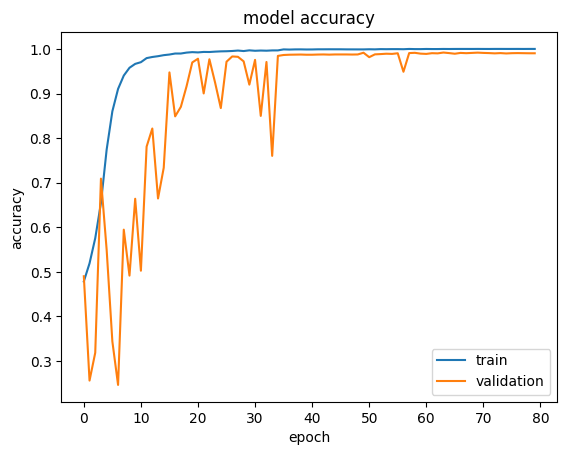

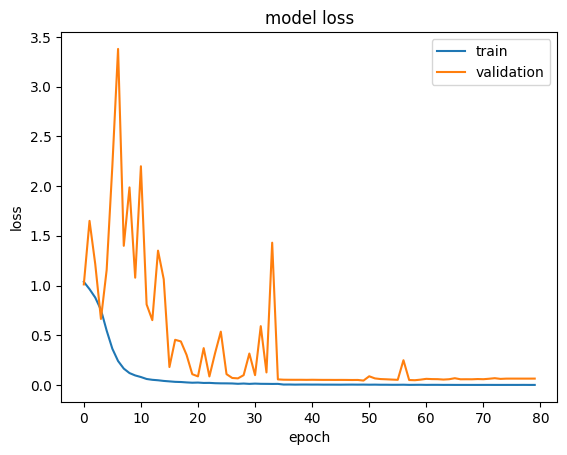

In [72]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [73]:
Y_prob = model.predict(test_images, batch_size=1)
print(Y_prob)

5787/5787 ━━━━━━━━━━━━━━━━━━━━ 67s 11ms/step
[[5.0980220e-06 3.2127708e-05 9.9996281e-01]
 [4.6973131e-03 9.9443454e-01 8.6820818e-04]
 [9.9997675e-01 1.2288168e-05 1.0992460e-05]
 ...
 [1.1367856e-05 9.9996376e-01 2.4944769e-05]
 [9.9997461e-01 1.6500297e-05 8.9509631e-06]
 [4.6162395e-06 4.3542164e-05 9.9995184e-01]]


In [74]:
y_pred = np.argmax(Y_prob, axis=1)
y_pred

array([2, 1, 0, ..., 1, 0, 2])

In [75]:
np.argmax(test_one_hot, axis=1)

array([2, 2, 0, ..., 1, 0, 2])

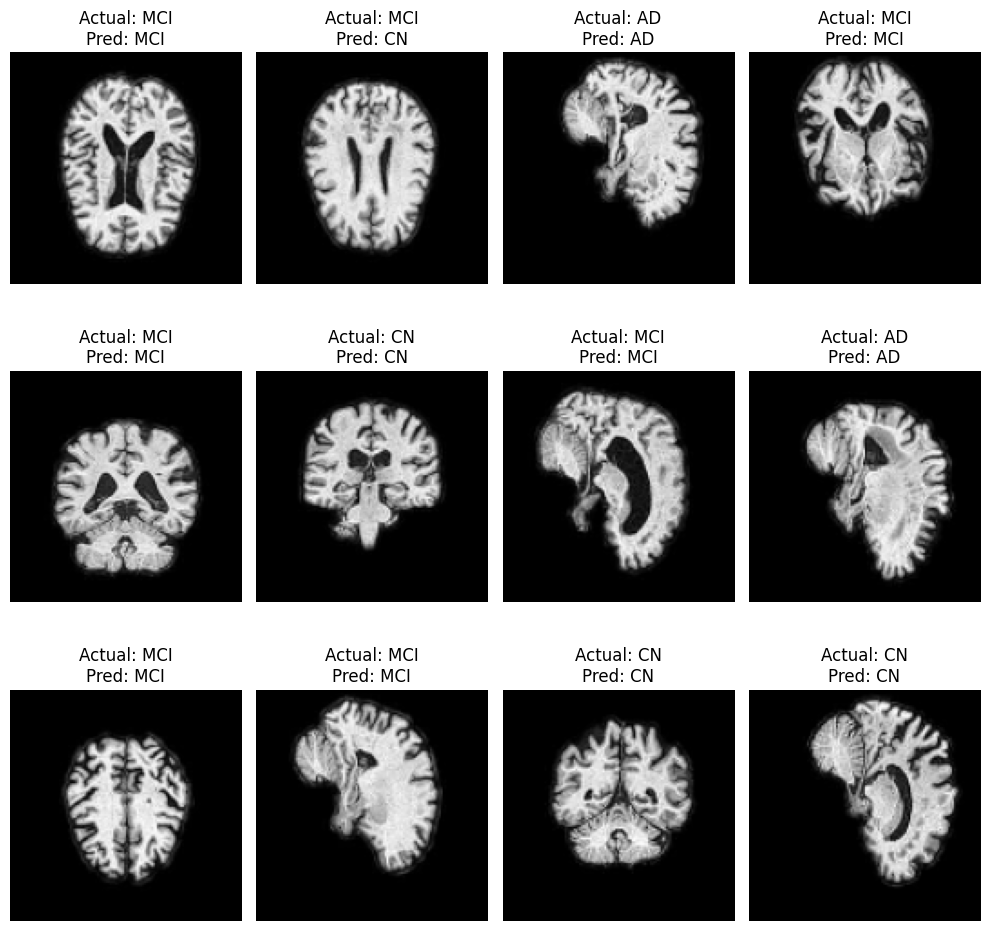

In [76]:
true_labels = test_encoded_labels#np.argmax(test_one_hot, axis=1)


num_images = min(12, len(test_images))  # Ensure we don't exceed the number of images available
columns = 4
rows = (num_images + columns - 1) // columns  
fig = plt.figure(figsize=(10, 10))
label_names = classes  

for i in range(1, num_images + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(test_images[i - 1])
#     actual_label = label_names[true_labels[i - 1]]
    actual_label = label_names[test_encoded_labels[i - 1]]
    predicted_label = label_names[y_pred[i - 1]]
    plt.title(f'Actual: {actual_label}\nPred: {predicted_label}')
    plt.axis('off')  

plt.tight_layout()
plt.show()

In [77]:
from sklearn.metrics import classification_report


# Compute accuracy score
report = classification_report(test_encoded_labels, y_pred, target_names=classes)

# Print classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

          AD       0.99      0.99      0.99      1197
          CN       0.99      0.99      0.99      1746
         MCI       0.99      0.99      0.99      2844

    accuracy                           0.99      5787
   macro avg       0.99      0.99      0.99      5787
weighted avg       0.99      0.99      0.99      5787



In [78]:
def calculate_metrics(pred_classes, gt_classes):
    


    accuracy = np.mean(pred_classes == gt_classes)

   
    confusion_matrix = np.zeros((3, 3), dtype=int)
    np.add.at(confusion_matrix, (gt_classes, pred_classes), 1)

    sensitivity = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)

    true_negatives = np.sum(confusion_matrix) - np.sum(np.diag(confusion_matrix))
    specificity = true_negatives / (np.sum(confusion_matrix) - np.sum(np.diag(confusion_matrix)))

    metrics = {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity
    }
    
    return metrics

In [79]:
print(calculate_metrics(y_pred, test_encoded_labels))

{'accuracy': 0.9917055469155003, 'sensitivity': array([0.98579783, 0.99427262, 0.99261603]), 'specificity': 1.0}


In [80]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Reds', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = classes, 
        yticklabels = classes)
    
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()
    


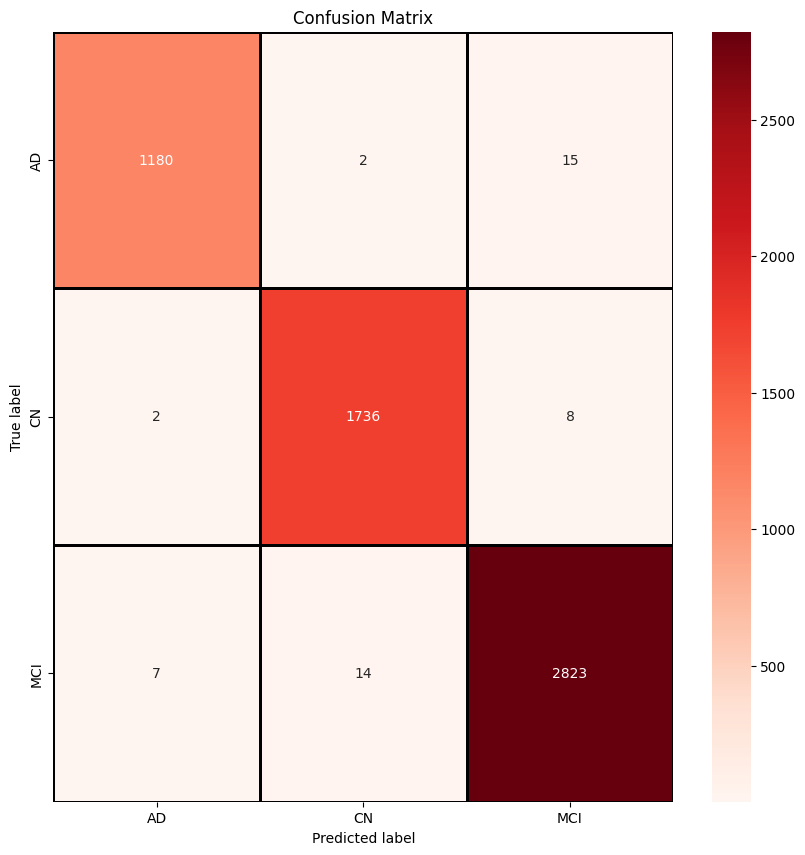

In [81]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(confusion_matrix(test_encoded_labels, y_pred))

In [82]:
def plot_confusion_matrix_perc(cm, classes):
    # Convert confusion matrix to percentages
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    plt.figure(figsize=(10, 10))
    sns.heatmap(
        cm_percentage, 
        cmap='Reds', 
        linecolor='black', 
        linewidth=1, 
        annot=True, 
        fmt='.2f',  # format the annotations to 2 decimal places
        xticklabels=classes, 
        yticklabels=classes
    )
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix (Percentage)')
    plt.show()

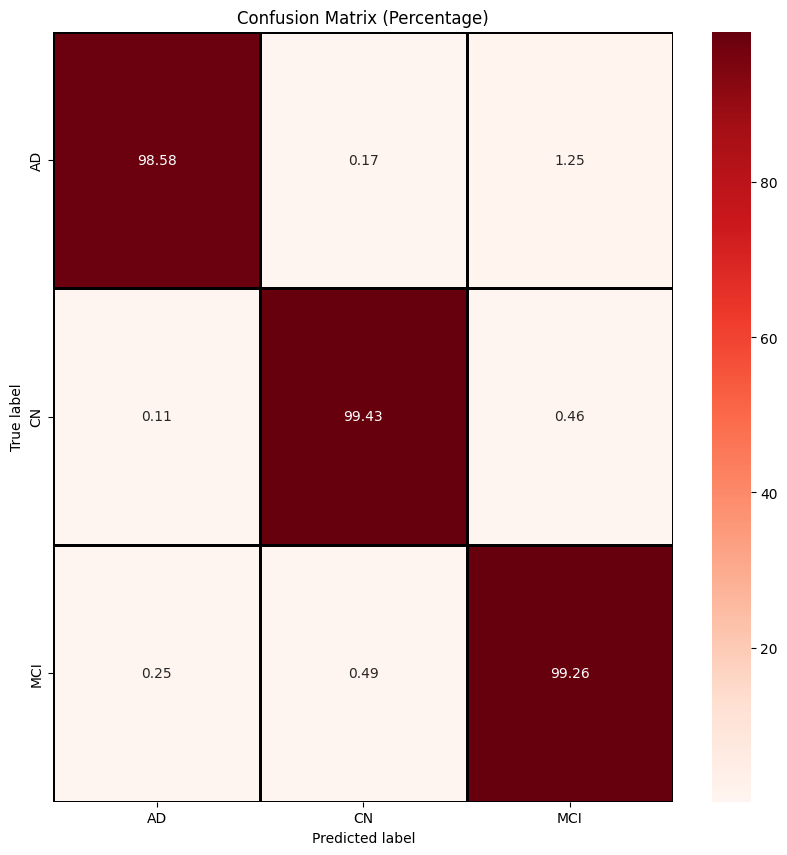

In [83]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix_perc(confusion_matrix(test_encoded_labels, y_pred), classes)